In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

train_path = r"C:\Users\Айбек\Desktop\data\train"
test_path = r"C:\Users\Айбек\Desktop\data\test"

In [2]:
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_path, target_size=(224, 224), batch_size=32, class_mode='categorical')
test_generator = test_datagen.flow_from_directory(test_path, target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False)

class_weights = compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weight_dict = dict(enumerate(class_weights))

Found 13492 images belonging to 100 classes.
Found 500 images belonging to 100 classes.


In [4]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False 

baseline_model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(train_generator.num_classes, activation='softmax') 
])

baseline_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_baseline = baseline_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    class_weight=class_weight_dict
)

baseline_score = baseline_model.evaluate(test_generator)
print(f"Baseline Model Accuracy: {baseline_score[1]:.4f}")

Epoch 1/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 1837s 4s/step - accuracy: 0.0635 - loss: 4.4051 - val_accuracy: 0.2937 - val_loss: 2.6838
Epoch 2/10
  1/421 ━━━━━━━━━━━━━━━━━━━━ 27:55 4s/step - accuracy: 0.1875 - loss: 3.2348

C:\ProgramData\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


421/421 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.1875 - loss: 3.2348 - val_accuracy: 0.8000 - val_loss: 1.0576
Epoch 3/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 1864s 4s/step - accuracy: 0.3216 - loss: 2.5953 - val_accuracy: 0.4417 - val_loss: 1.9809
Epoch 4/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.4688 - loss: 2.0945 - val_accuracy: 0.6000 - val_loss: 1.1050
Epoch 5/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 1759s 4s/step - accuracy: 0.4405 - loss: 2.0474 - val_accuracy: 0.5000 - val_loss: 1.7175
Epoch 6/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.3125 - loss: 2.6249 - val_accuracy: 0.8500 - val_loss: 0.4889
Epoch 7/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 1697s 4s/step - accuracy: 0.4906 - loss: 1.7806 - val_accuracy: 0.5542 - val_loss: 1.5258
Epoch 8/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6562 - loss: 1.3890 - val_accuracy: 0.8500 - val_loss: 0.4186
Epoch 9/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 1717s 4s/step - accuracy: 0.5351 - loss: 1.6040 - val_accuracy: 0.558

In [5]:
enhanced_model = models.Sequential([
    base_model,  
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),  
    layers.Dense(train_generator.num_classes, activation='softmax')
])

base_model.trainable = True
for layer in base_model.layers[:-4]:
    layer.trainable = False  

enhanced_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_enhanced = enhanced_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    class_weight=class_weight_dict
)

enhanced_score = enhanced_model.evaluate(test_generator)
print(f"Enhanced Model Accuracy: {enhanced_score[1]:.4f}")

baseline_predictions = baseline_model.predict(test_generator, verbose=1).argmax(axis=1)
enhanced_predictions = enhanced_model.predict(test_generator, verbose=1).argmax(axis=1)

true_classes = test_generator.classes

print("Baseline Model Metrics:")
print(classification_report(true_classes, baseline_predictions, zero_division=0))

print("Enhanced Model Metrics:")
print(classification_report(true_classes, enhanced_predictions, zero_division=0))

Epoch 1/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 2091s 5s/step - accuracy: 0.0645 - loss: 4.3277 - val_accuracy: 0.1417 - val_loss: 3.8749
Epoch 2/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.1562 - loss: 3.6831 - val_accuracy: 0.1000 - val_loss: 3.8348
Epoch 3/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 3483s 8s/step - accuracy: 0.2546 - loss: 2.9548 - val_accuracy: 0.4125 - val_loss: 2.7405
Epoch 4/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.4375 - loss: 2.6954 - val_accuracy: 0.4000 - val_loss: 1.9555
Epoch 5/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 2985s 7s/step - accuracy: 0.4072 - loss: 2.2377 - val_accuracy: 0.6271 - val_loss: 1.3669
Epoch 6/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.4688 - loss: 2.2382 - val_accuracy: 0.7000 - val_loss: 1.2791
Epoch 7/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 2339s 6s/step - accuracy: 0.4805 - loss: 1.8900 - val_accuracy: 0.5979 - val_loss: 1.3770
Epoch 8/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.3750 - loss: 2.0574 - val_ac

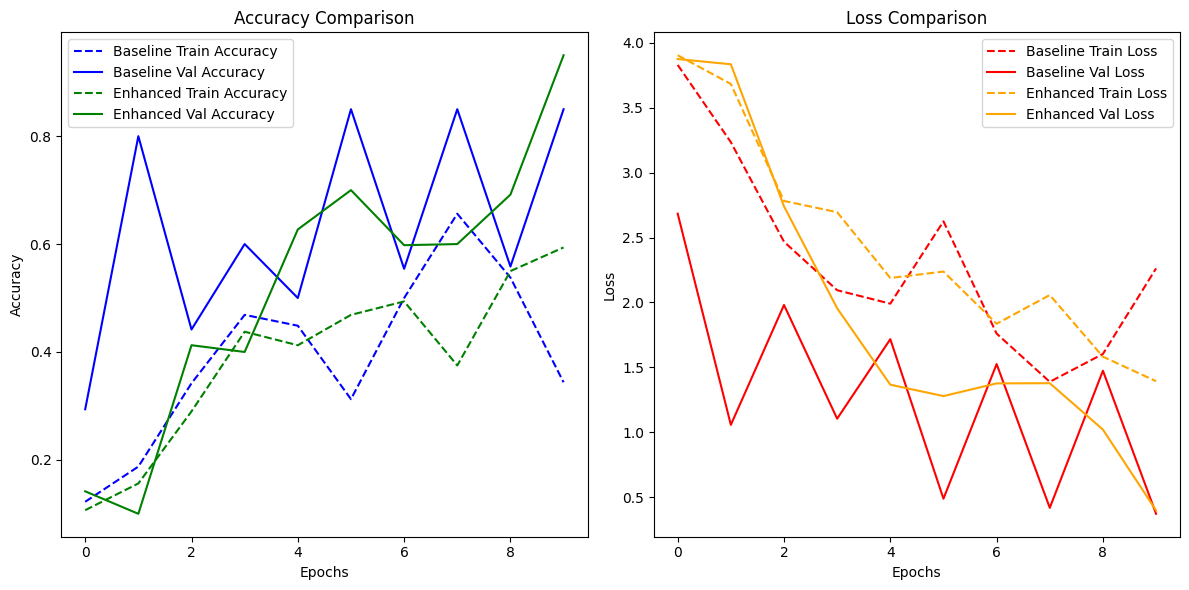

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_baseline.history["accuracy"], label="Baseline Train Accuracy", linestyle='--', color='blue')
plt.plot(history_baseline.history["val_accuracy"], label="Baseline Val Accuracy", linestyle='-', color='blue')
plt.plot(history_enhanced.history["accuracy"], label="Enhanced Train Accuracy", linestyle='--', color='green')
plt.plot(history_enhanced.history["val_accuracy"], label="Enhanced Val Accuracy", linestyle='-', color='green')
plt.title("Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_baseline.history["loss"], label="Baseline Train Loss", linestyle='--', color='red')
plt.plot(history_baseline.history["val_loss"], label="Baseline Val Loss", linestyle='-', color='red')
plt.plot(history_enhanced.history["loss"], label="Enhanced Train Loss", linestyle='--', color='orange')
plt.plot(history_enhanced.history["val_loss"], label="Enhanced Val Loss", linestyle='-', color='orange')
plt.title("Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()